# Lesson 21: Ensemble learning demonstration

This notebook demonstrates key concepts and tools for training ensemble models.

## Notebook set up

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    VotingClassifier,
    BaggingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    StackingClassifier
)
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

### Dataset

In [2]:
# Generate synthetic dataset, similar to Lesson 20: classification but 
# more challenging with: more features, redundant features, and noise
data = make_classification(
    n_samples=10000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    n_clusters_per_class=3,
    weights=[0.9, 0.1],
    flip_y=0.1,
    class_sep=0.5,
    random_state=315
)

# Create dataframe with feature columns
df = pd.DataFrame(data[0], columns=[f'feature_{i}' for i in range(data[0].shape[1])])
df['target'] = data[1]

# Split into train (75%) and test (25%) sets
train_df, test_df = train_test_split(df, random_state=315)
train_df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,target
6850,2.056957,0.222830,-1.914398,1.095708,-2.389691,-1.113905,1.296463,-5.769138,-1.742394,-1.717438,...,0.903576,-1.730474,-0.211586,0.402758,-2.171021,1.242654,-0.993714,1.083335,1.735312,0
5856,1.776417,-3.711362,-0.042654,-4.450805,0.283605,0.062951,-2.952074,-4.635668,0.133406,-1.665485,...,-1.160329,1.273855,-2.754988,-5.904544,-0.580578,0.952436,-0.566598,-1.590927,0.632844,0
2483,-0.017753,1.031828,-2.485858,-0.667876,-1.021137,-0.692445,0.630700,2.300769,-1.097844,0.717599,...,-0.728046,0.328055,0.403882,1.735435,0.162798,-1.306485,-0.760256,0.780826,-1.476193,0
4915,-0.495843,2.895735,-2.537299,-2.609338,-0.875950,2.935914,3.253340,6.378967,-0.058042,-1.338881,...,-1.579209,1.383636,0.879382,2.941039,-0.171335,0.508342,-0.704955,1.260240,-2.110639,0
4598,0.899913,-0.241683,-1.206857,-4.108075,0.786454,-0.923499,-1.404900,-6.952240,-1.282080,-1.646648,...,3.731664,1.857395,-0.758554,4.081466,2.046172,0.938040,-0.088168,-0.283488,0.257320,0


## 1. Baseline models

Scikit-learn [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) implementation

In [3]:
# Logistic regression baseline
lr_clf = LogisticRegression(random_state=315, max_iter=1000, class_weight='balanced')

lr_scores = cross_validate(
    lr_clf,
    train_df.drop('target', axis=1),
    train_df['target'],
    cv=7,
    scoring=['roc_auc', 'f1'],
    return_train_score=False
)

lr_auc = lr_scores['test_roc_auc']
lr_f1 = lr_scores['test_f1']

print(f'Logistic Regression - AUC: {lr_auc.mean():.3f} (+/- {lr_auc.std():.3f}), F1: {lr_f1.mean():.3f} (+/- {lr_f1.std():.3f})')

lr_clf.fit(train_df.drop('target', axis=1), train_df['target'])
lr_pred = lr_clf.predict(test_df.drop('target', axis=1))

Logistic Regression - AUC: 0.663 (+/- 0.026), F1: 0.305 (+/- 0.016)


Scikit-learn [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) implementation

In [4]:
# Decision tree baseline
dt_clf = DecisionTreeClassifier(random_state=315, class_weight='balanced')

dt_scores = cross_validate(
    dt_clf,
    train_df.drop('target', axis=1),
    train_df['target'],
    cv=7,
    scoring=['roc_auc', 'f1'],
    return_train_score=False
)

dt_auc = dt_scores['test_roc_auc']
dt_f1 = dt_scores['test_f1']

print(f'Decision Tree - AUC: {dt_auc.mean():.3f} (+/- {dt_auc.std():.3f}), F1: {dt_f1.mean():.3f} (+/- {dt_f1.std():.3f})')

dt_clf.fit(train_df.drop('target', axis=1), train_df['target'])
dt_pred = dt_clf.predict(test_df.drop('target', axis=1))

Decision Tree - AUC: 0.600 (+/- 0.015), F1: 0.307 (+/- 0.025)


## 2. Parallel ensembles

### 2.1. Voting ensemble

Combines predictions from multiple independent models by majority vote (hard voting) or by averaging predicted probabilities (soft voting).

Scikit-learn [Voting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) implementation

In [5]:
# Create voting classifier with soft voting
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=315, max_iter=1000, class_weight='balanced')),
        ('dt', DecisionTreeClassifier(random_state=315, class_weight='balanced')),
        ('svm', SVC(probability=True, random_state=315, class_weight='balanced'))
    ],
    voting='soft'
)

voting_scores = cross_validate(
    voting_clf,
    train_df.drop('target', axis=1),
    train_df['target'],
    cv=7,
    scoring=['roc_auc', 'f1'],
    return_train_score=False
)

voting_auc = voting_scores['test_roc_auc']
voting_f1 = voting_scores['test_f1']

print(f'Voting - AUC: {voting_auc.mean():.3f} (+/- {voting_auc.std():.3f}), F1: {voting_f1.mean():.3f} (+/- {voting_f1.std():.3f})')

voting_clf.fit(train_df.drop('target', axis=1), train_df['target'])
voting_pred = voting_clf.predict(test_df.drop('target', axis=1))

Voting - AUC: 0.764 (+/- 0.015), F1: 0.361 (+/- 0.022)


### 2.2. Bagging ensemble

Trains multiple instances of the same model on different random subsets of the training data (with replacement), then averages their predictions to reduce variance.

Scikit-learn [Bagging Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) implementation

In [6]:
# Create bagging classifier with decision trees
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=315, class_weight='balanced'),
    n_estimators=100,
    random_state=315,
    oob_score=True
)

bagging_scores = cross_validate(
    bagging_clf,
    train_df.drop('target', axis=1),
    train_df['target'],
    cv=7,
    scoring=['roc_auc', 'f1'],
    return_train_score=False
)

bagging_auc = bagging_scores['test_roc_auc']
bagging_f1 = bagging_scores['test_f1']

print(f'Bagging - AUC: {bagging_auc.mean():.3f} (+/- {bagging_auc.std():.3f}), F1: {bagging_f1.mean():.3f} (+/- {bagging_f1.std():.3f})')

bagging_clf.fit(train_df.drop('target', axis=1), train_df['target'])
bagging_pred = bagging_clf.predict(test_df.drop('target', axis=1))

Bagging - AUC: 0.783 (+/- 0.024), F1: 0.244 (+/- 0.034)


### 2.3. Random forest

An extension of bagging that uses decision trees as base models and introduces additional randomness by considering only a random subset of features at each split.

Scikit-learn [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) implementation

In [7]:
# Create random forest classifier
rf_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=315,
    oob_score=True,
    class_weight='balanced'
)

rf_scores = cross_validate(
    rf_clf,
    train_df.drop('target', axis=1),
    train_df['target'],
    cv=7,
    scoring=['roc_auc', 'f1'],
    return_train_score=False
)

rf_auc = rf_scores['test_roc_auc']
rf_f1 = rf_scores['test_f1']

print(f'Random Forest - AUC: {rf_auc.mean():.3f} (+/- {rf_auc.std():.3f}), F1: {rf_f1.mean():.3f} (+/- {rf_f1.std():.3f})')

rf_clf.fit(train_df.drop('target', axis=1), train_df['target'])
rf_pred = rf_clf.predict(test_df.drop('target', axis=1))

Random Forest - AUC: 0.792 (+/- 0.026), F1: 0.159 (+/- 0.013)


## 3. Serial (sequential) ensembles

### 3.1. AdaBoost

Sequentially trains weak learners where each new model focuses more on the examples that previous models misclassified by adjusting sample weights.

Scikit-learn [AdaBoost Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) implementation

In [8]:
# Create AdaBoost classifier
adaboost_clf = AdaBoostClassifier(
    n_estimators=100,
    random_state=315
)

adaboost_scores = cross_validate(
    adaboost_clf,
    train_df.drop('target', axis=1),
    train_df['target'],
    cv=7,
    scoring=['roc_auc', 'f1'],
    return_train_score=False
)

adaboost_auc = adaboost_scores['test_roc_auc']
adaboost_f1 = adaboost_scores['test_f1']

print(f'AdaBoost - AUC: {adaboost_auc.mean():.3f} (+/- {adaboost_auc.std():.3f}), F1: {adaboost_f1.mean():.3f} (+/- {adaboost_f1.std():.3f})')

adaboost_clf.fit(train_df.drop('target', axis=1), train_df['target'])
adaboost_pred = adaboost_clf.predict(test_df.drop('target', axis=1))

AdaBoost - AUC: 0.684 (+/- 0.028), F1: 0.086 (+/- 0.022)


### 3.2. Gradient Boosting

Builds models sequentially where each new model is trained to predict the residual errors of the previous ensemble, using gradient descent to minimize a loss function.

Scikit-learn [Gradient Boosting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) implementation

In [9]:
# Create Gradient Boosting classifier
gb_clf = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=315
)

gb_scores = cross_validate(
    gb_clf,
    train_df.drop('target', axis=1),
    train_df['target'],
    cv=7,
    scoring=['roc_auc', 'f1'],
    return_train_score=False
)

gb_auc = gb_scores['test_roc_auc']
gb_f1 = gb_scores['test_f1']

print(f'Gradient Boosting - AUC: {gb_auc.mean():.3f} (+/- {gb_auc.std():.3f}), F1: {gb_f1.mean():.3f} (+/- {gb_f1.std():.3f})')

gb_clf.fit(train_df.drop('target', axis=1), train_df['target'])
gb_pred = gb_clf.predict(test_df.drop('target', axis=1))

Gradient Boosting - AUC: 0.736 (+/- 0.023), F1: 0.226 (+/- 0.031)


### 3.3. Stacking ensemble

Trains multiple diverse base models, then uses their predictions as input features for a meta-model that learns how to best combine them.

Scikit-learn [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html) implementation

In [10]:
# Create stacking classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=50, random_state=315, class_weight='balanced')),
        ('dt', DecisionTreeClassifier(max_depth=5, random_state=315, class_weight='balanced')),
        ('svm', SVC(probability=True, random_state=315, class_weight='balanced'))
    ],
    final_estimator=LogisticRegression(random_state=315, max_iter=1000, class_weight='balanced'),
    cv=7
)

stacking_scores = cross_validate(
    stacking_clf,
    train_df.drop('target', axis=1),
    train_df['target'],
    cv=7,
    scoring=['roc_auc', 'f1'],
    return_train_score=False
)

stacking_auc = stacking_scores['test_roc_auc']
stacking_f1 = stacking_scores['test_f1']

print(f'Stacking - AUC: {stacking_auc.mean():.3f} (+/- {stacking_auc.std():.3f}), F1: {stacking_f1.mean():.3f} (+/- {stacking_f1.std():.3f})')

stacking_clf.fit(train_df.drop('target', axis=1), train_df['target'])
stacking_pred = stacking_clf.predict(test_df.drop('target', axis=1))

Stacking - AUC: 0.813 (+/- 0.023), F1: 0.522 (+/- 0.019)


## 4. Model comparison

In [12]:
# Collect results
results = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Voting', 'Bagging', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'Stacking'],
    'AUC': [lr_auc, dt_auc, voting_auc, bagging_auc, rf_auc, adaboost_auc, gb_auc, stacking_auc],
    'F1': [lr_f1, dt_f1, voting_f1, bagging_f1, rf_f1, adaboost_f1, gb_f1, stacking_f1],
    'Predictions': [lr_pred, dt_pred, voting_pred, bagging_pred, rf_pred, adaboost_pred, gb_pred, stacking_pred]
}

results_df = pd.DataFrame({
    'Model': results['Model'],
    'AUC Mean': [auc.mean() for auc in results['AUC']],
    'AUC Std': [auc.std() for auc in results['AUC']],
    'F1 Mean': [f1.mean() for f1 in results['F1']],
    'F1 Std': [f1.std() for f1 in results['F1']]
})

results_df

,Model,AUC Mean,AUC Std,F1 Mean,F1 Std
0,Logistic Regression,0.662758,0.025827,0.304572,0.016444
1,Decision Tree,0.599774,0.015110,0.307292,0.025058
2,Voting,0.763999,0.014770,0.360892,0.021863
3,Bagging,0.783047,0.023869,0.243632,0.033601
4,Random Forest,0.791838,0.026019,0.158510,0.012615
5,AdaBoost,0.683823,0.028357,0.085703,0.022349
6,Gradient Boosting,0.736249,0.022935,0.225941,0.030542
7,Stacking,0.812724,0.023151,0.521644,0.018951


### 4.1. Score comparison

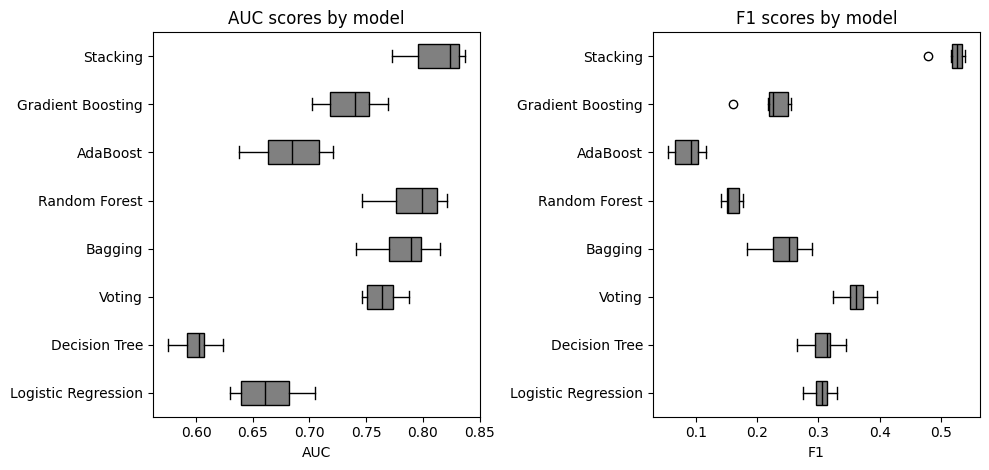

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4.8))

# AUC boxplot
auc_data = [auc for auc in results['AUC']]

axes[0].boxplot(
    auc_data,
    tick_labels=results['Model'],
    patch_artist=True,
    vert=False
)

axes[0].set_title('AUC scores by model')
axes[0].set_xlabel('AUC')

# F1 boxplot
f1_data = [f1 for f1 in results['F1']]

axes[1].boxplot(
    f1_data,
    tick_labels=results['Model'],
    patch_artist=True,
    vert=False
)

axes[1].set_title('F1 scores by model')
axes[1].set_xlabel('F1')

plt.tight_layout()
plt.show()

### 4.2. Confusion matrix comparison

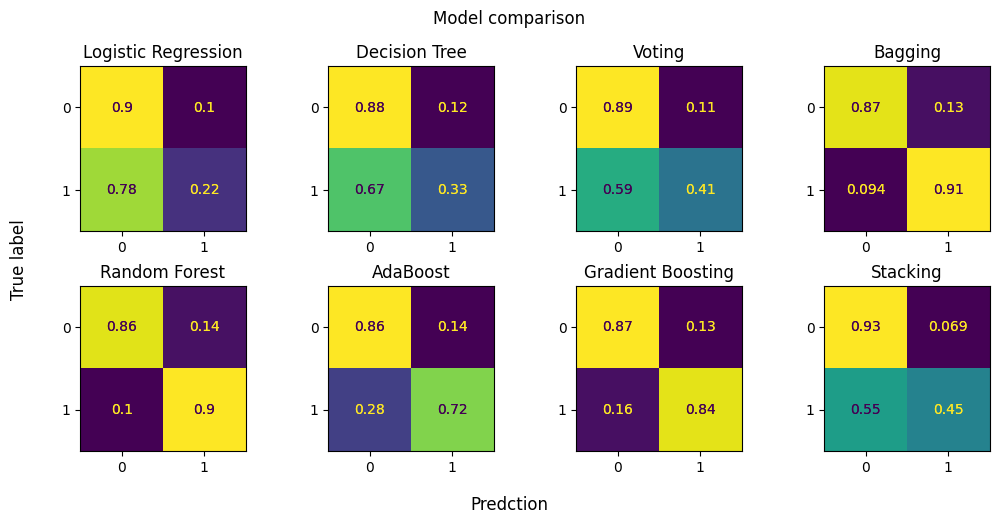

In [15]:
ncols = 4
nrows = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*2.6, nrows*2.6))
axes = axes.flatten()

fig.suptitle('Model comparison')
fig.supylabel('True label')
fig.supxlabel('Predction')

for i, (model_name, pred) in enumerate(zip(results['Model'], results['Predictions'])):

    cm = confusion_matrix(test_df['target'], pred)
    disp = ConfusionMatrixDisplay.from_predictions(
        pred,
        test_df['target'],
        normalize='true',
        ax=axes[i],
        colorbar=False
    )
    disp.plot(ax=axes[i], colorbar=False)
    axes[i].set_title(model_name)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()